In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.callbacks import Callback
from sklearn.metrics import f1_score

In [2]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y_true = self.validation_data
        y_pred_probs = self.model.predict(val_x)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(val_y_true, axis=1)

        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        print(f'\nEpoch {epoch + 1} - Macro F1-score: {f1:.4f}')

    def on_train_end(self, logs=None):
        plt.plot(range(1, len(self.f1_scores) + 1), self.f1_scores, marker='o')
        plt.title('Macro F1-Score Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# 2. One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

In [5]:
# 3. Data generators (rescale done by generator)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
# no need for train_datagen.fit(x_train) here
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_test, y_test, batch_size=64)

# Get one batch from your validation generator to use for evaluation
val_x, val_y = next(val_generator)
f1_callback = F1ScoreCallback(validation_data=(val_x, val_y))


In [11]:
# 4. Build model that accepts 32x32 inputs
def build_cnn_4conv(input_shape=(32,32,3), num_classes=10):
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # Block 2
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # Block 3
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    # Block 4
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_cnn_4conv(input_shape=(32,32,3), num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Akhila\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

C:\Users\Akhila\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 

Epoch 1 - Macro F1-score: 0.3661
781/781 - 138s - 177ms/step - accuracy: 0.3480 - loss: 1.8061 - val_accuracy: 0.3643 - val_loss: 2.3056
Epoch 2/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Epoch 2 - Macro F1-score: 0.3599
781/781 - 5s - 6ms/step - accuracy: 0.4688 - loss: 1.6424 - val_accuracy: 0.5000 - val_loss: 1.4038
Epoch 3/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Epoch 3 - Macro F1-score: 0.6687
781/781 - 124s - 159ms/step - accuracy: 0.4630 - loss: 1.4786 - val_accuracy: 0.5254 - val_loss: 1.3791
Epoch 4/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Epoch 4 - Macro F1-score: 0.6588
781/781 - 0s - 629us/step - accuracy: 0.4375 - loss: 1.4191 - val_accuracy: 0.6875 - val_loss: 0.8969
Epoch 5/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Epoch 5 - Macro F1-score: 0.4597
781/781 - 142s - 182ms/step - accuracy: 0.5176 - loss: 1.3542 - val_accuracy: 0.4921 - val_loss: 1.4568
Epoch 6/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Epoch 6 - Macro F1-score: 0.4242
781/781 - 1s - 765us/step - accuracy: 0.5000 - loss: 1.4529 - val_accuracy: 0.4375 - val_loss: 1.5230
Epoch 7/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 

Epoch 7 - Macro F1-score: 0.5458
781/781 - 142s - 182ms/step - accuracy: 0.5525 - loss: 1.2623 - val_accuracy: 0.4997 - val_loss: 1.5448
Epoch 8/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Epoch 8 - Macro F1-score: 0.5639
781/781 - 1s - 643us/step - accuracy: 0.5938 - loss: 1.2085 - val_accuracy: 0.6875 - val_loss: 0.7198
Epoch 9/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 9 - Macro F1-score: 0.7423
781/781 - 126s - 161ms/step - accuracy: 0.5810 - loss: 1.1944 - val_accuracy: 0.6480 - val_loss: 1.0363
Epoch 10/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Epoch 10 - Macro F1-score: 0.7423
781/781 - 5s - 6ms/step - accuracy: 0.5781 - loss: 1.2768 - val_accuracy: 0.8750 - val_loss: 0.4322
Epoch 11/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Epoch 11 - Macro F1-score: 0.6868
781/781 - 128s - 164ms/step - accuracy: 0.6006 - loss: 1.1404 - val_accuracy: 0.6253 - val_loss: 1.1836
Epoch 12/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 12 - Macro F1-score: 0.6036
781/781 - 5s - 6ms/step - accuracy: 0.6562 - loss: 1.0715 - val_accuracy: 0.4375 - val_loss: 1.1948
Epoch 13/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Epoch 13 - Macro F1-score: 0.6136
781/781 - 128s - 164ms/step - accuracy: 0.6201 - loss: 1.0865 - val_accuracy: 0.5890 - val_loss: 1.2673
Epoch 14/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 14 - Macro F1-score: 0.6313
781/781 - 0s - 589us/step - accuracy: 0.7344 - loss: 0.7769 - val_accuracy: 0.5625 - val_loss: 1.6348
Epoch 15/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Epoch 15 - Macro F1-score: 0.5386
781/781 - 129s - 165ms/step - accuracy: 0.6340 - loss: 1.0521 - val_accuracy: 0.5324 - val_loss: 1.6053
Epoch 16/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Epoch 16 - Macro F1-score: 0.5534
781/781 - 0s - 631us/step - accuracy: 0.5469 - loss: 1.1176 - val_accuracy: 0.5000 - val_loss: 1.7397
Epoch 17/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Epoch 17 - Macro F1-score: 0.7642
781/781 - 133s - 171ms/step - accuracy: 0.6430 - loss: 1.0283 - val_accuracy: 0.6943 - val_loss: 0.9244
Epoch 18/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Epoch 18 - Macro F1-score: 0.7690
781/781 - 0s - 602us/step - accuracy: 0.6406 - loss: 1.0047 - val_accuracy: 0.8125 - val_loss: 0.5004
Epoch 19/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Epoch 19 - Macro F1-score: 0.7226
781/781 - 133s - 170ms/step - accuracy: 0.6545 - loss: 1.0025 - val_accuracy: 0.7095 - val_loss: 0.8443
Epoch 20/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Epoch 20 - Macro F1-score: 0.7409
781/781 - 5s - 6ms/step - accuracy: 0.5938 - loss: 1.1067 - val_accuracy: 0.7500 - val_loss: 0.5643
Epoch 21/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 21 - Macro F1-score: 0.6446
781/781 - 129s - 165ms/step - accuracy: 0.6602 - loss: 0.9766 - val_accuracy: 0.6034 - val_loss: 1.2466
Epoch 22/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 22 - Macro F1-score: 0.7090
781/781 - 0s - 614us/step - accuracy: 0.6250 - loss: 1.1152 - val_accuracy: 0.4375 - val_loss: 1.0675
Epoch 23/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Epoch 23 - Macro F1-score: 0.8141
781/781 - 124s - 159ms/step - accuracy: 0.6700 - loss: 0.9529 - val_accuracy: 0.7257 - val_loss: 0.8151
Epoch 24/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 24 - Macro F1-score: 0.8413
781/781 - 0s - 633us/step - accuracy: 0.6562 - loss: 0.8387 - val_accuracy: 0.9375 - val_loss: 0.1542
Epoch 25/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 25 - Macro F1-score: 0.7667
781/781 - 125s - 160ms/step - accuracy: 0.6783 - loss: 0.9403 - val_accuracy: 0.6895 - val_loss: 0.9154
Epoch 26/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Epoch 26 - Macro F1-score: 0.7667
781/781 - 5s - 7ms/step - accuracy: 0.7188 - loss: 0.9130 - val_accuracy: 0.8750 - val_loss: 0.5830
Epoch 27/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 27 - Macro F1-score: 0.8205
781/781 - 125s - 160ms/step - accuracy: 0.6836 - loss: 0.9176 - val_accuracy: 0.7562 - val_loss: 0.7289
Epoch 28/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 28 - Macro F1-score: 0.8205
781/781 - 1s - 656us/step - accuracy: 0.6562 - loss: 0.8707 - val_accuracy: 0.8750 - val_loss: 0.4447
Epoch 29/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 29 - Macro F1-score: 0.5815
781/781 - 125s - 160ms/step - accuracy: 0.6906 - loss: 0.8985 - val_accuracy: 0.6037 - val_loss: 1.3885
Epoch 30/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 30 - Macro F1-score: 0.5799
781/781 - 5s - 7ms/step - accuracy: 0.6719 - loss: 0.9436 - val_accuracy: 0.6875 - val_loss: 1.4851
Epoch 31/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 31 - Macro F1-score: 0.7997
781/781 - 128s - 164ms/step - accuracy: 0.6918 - loss: 0.8908 - val_accuracy: 0.7162 - val_loss: 0.8629
Epoch 32/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Epoch 32 - Macro F1-score: 0.8030
781/781 - 0s - 584us/step - accuracy: 0.7031 - loss: 0.8581 - val_accuracy: 0.8125 - val_loss: 0.3952
Epoch 33/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Epoch 33 - Macro F1-score: 0.7447
781/781 - 129s - 165ms/step - accuracy: 0.6984 - loss: 0.8795 - val_accuracy: 0.7089 - val_loss: 0.8554
Epoch 34/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Epoch 34 - Macro F1-score: 0.6750
781/781 - 5s - 6ms/step - accuracy: 0.7656 - loss: 0.9552 - val_accuracy: 0.7500 - val_loss: 0.6690
Epoch 35/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 35 - Macro F1-score: 0.8209
781/781 - 129s - 165ms/step - accuracy: 0.7059 - loss: 0.8566 - val_accuracy: 0.7456 - val_loss: 0.7630
Epoch 36/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 36 - Macro F1-score: 0.8209
781/781 - 0s - 596us/step - accuracy: 0.7031 - loss: 0.8376 - val_accuracy: 0.6875 - val_loss: 1.3056
Epoch 37/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Epoch 37 - Macro F1-score: 0.8145
781/781 - 130s - 166ms/step - accuracy: 0.7062 - loss: 0.8549 - val_accuracy: 0.7729 - val_loss: 0.6505
Epoch 38/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Epoch 38 - Macro F1-score: 0.8145
781/781 - 0s - 606us/step - accuracy: 0.7344 - loss: 0.8002 - val_accuracy: 0.8750 - val_loss: 0.3502
Epoch 39/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Epoch 39 - Macro F1-score: 0.8557
781/781 - 127s - 163ms/step - accuracy: 0.7092 - loss: 0.8430 - val_accuracy: 0.7419 - val_loss: 0.8160
Epoch 40/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Epoch 40 - Macro F1-score: 0.8755
781/781 - 0s - 577us/step - accuracy: 0.7031 - loss: 0.7746 - val_accuracy: 0.6875 - val_loss: 0.8670
Epoch 41/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Epoch 41 - Macro F1-score: 0.7632
781/781 - 128s - 164ms/step - accuracy: 0.7107 - loss: 0.8378 - val_accuracy: 0.7315 - val_loss: 0.7990
Epoch 42/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 42 - Macro F1-score: 0.7632
781/781 - 0s - 588us/step - accuracy: 0.7188 - loss: 0.7385 - val_accuracy: 0.4375 - val_loss: 1.1268
Epoch 43/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Epoch 43 - Macro F1-score: 0.9102
781/781 - 128s - 164ms/step - accuracy: 0.7162 - loss: 0.8215 - val_accuracy: 0.7726 - val_loss: 0.6637
Epoch 44/45


C:\Users\Akhila\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Epoch 44 - Macro F1-score: 0.9102
781/781 - 0s - 576us/step - accuracy: 0.6719 - loss: 0.7930 - val_accuracy: 0.8125 - val_loss: 0.4100
Epoch 45/45
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Epoch 45 - Macro F1-score: 0.7565
781/781 - 130s - 166ms/step - accuracy: 0.7199 - loss: 0.8149 - val_accuracy: 0.7214 - val_loss: 0.8521


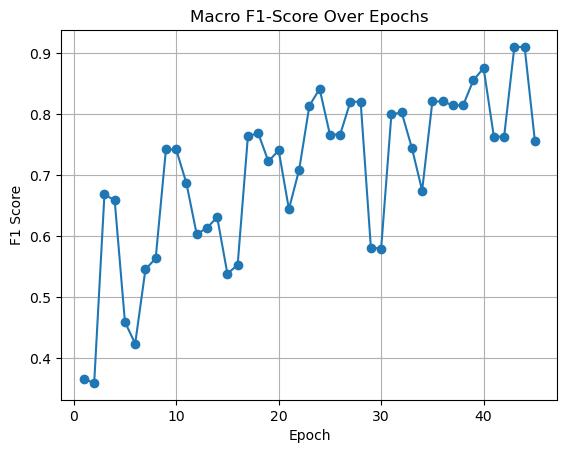

In [12]:
# 6. Train using generators
history = model.fit(
    train_generator,
    steps_per_epoch = len(x_train) // 64,
    epochs=45,
    validation_data=val_generator,
    validation_steps=len(x_test)//64,
    callbacks=[f1_callback],
    verbose=2
)


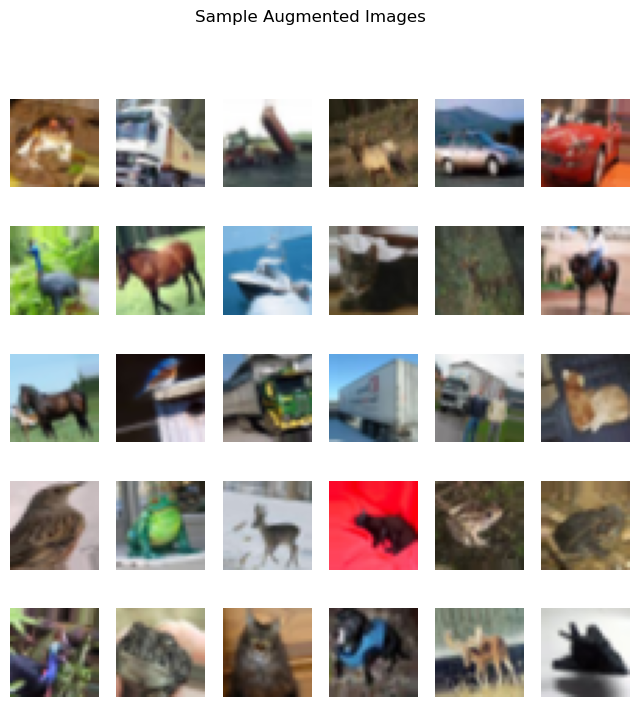

In [13]:
import matplotlib.pyplot as plt
import numpy as np

sample_images = x_train[:30]

augmented_images = next(train_datagen.flow(sample_images, batch_size=30,shuffle=False))

# Plot the augmented images in a 4x4 grid
plt.figure(figsize=(8,8))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis('off')
    # If images are normalized [0,1], scale them
    plt.imshow(augmented_images[i])
plt.suptitle("Sample Augmented Images")
plt.show()

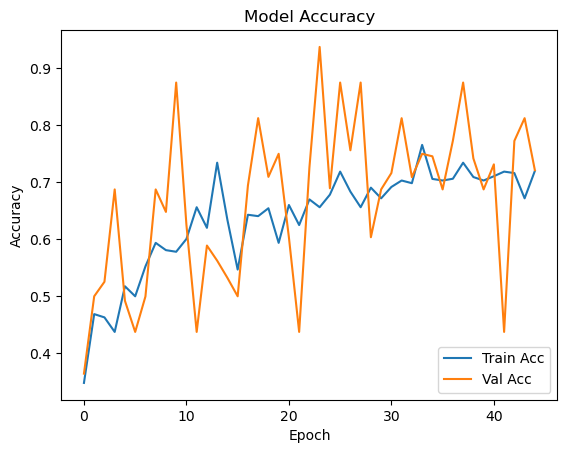

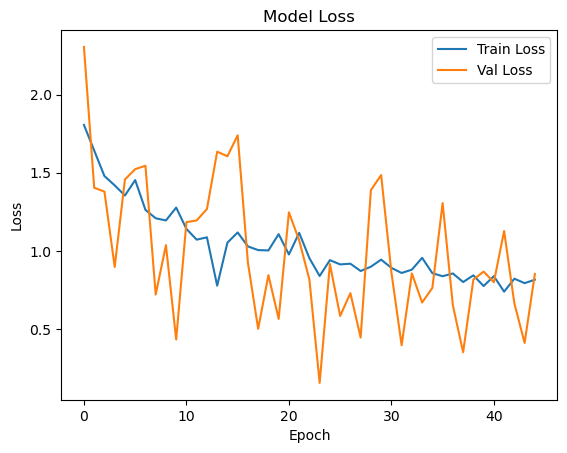

Test accuracy: 0.7208


In [14]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 8. Plot training & validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 9. Evaluate on test set
test_loss, test_acc = model.evaluate(val_generator, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


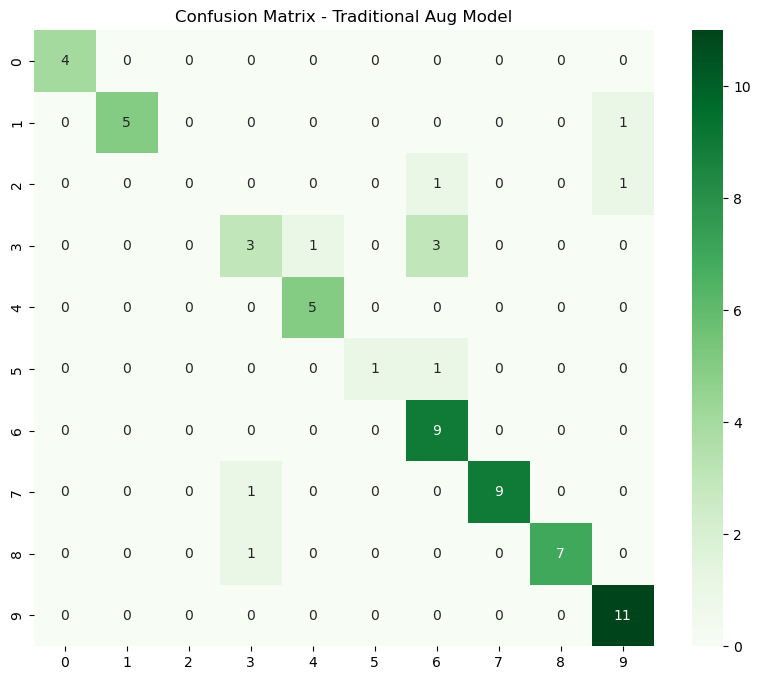

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.83      0.91         6
           2       0.00      0.00      0.00         2
           3       0.60      0.43      0.50         7
           4       0.83      1.00      0.91         5
           5       1.00      0.50      0.67         2
           6       0.64      1.00      0.78         9
           7       1.00      0.90      0.95        10
           8       1.00      0.88      0.93         8
           9       0.85      1.00      0.92        11

    accuracy                           0.84        64
   macro avg       0.79      0.75      0.76        64
weighted avg       0.84      0.84      0.83        64



C:\Users\Akhila\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akhila\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akhila\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(val_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(val_y, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Traditional Aug Model')
plt.show()

print(classification_report(y_true, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


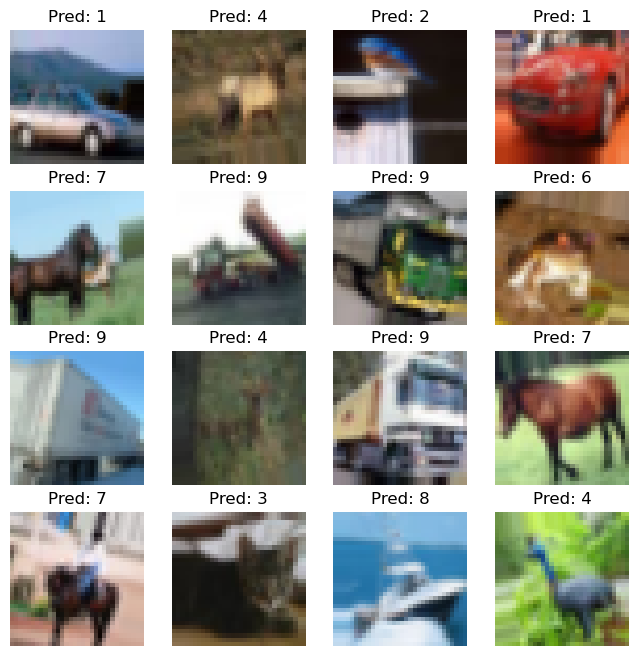

In [17]:
import matplotlib.pyplot as plt

# Take a sample batch (adjust x_train to your real data array)
sample_images = x_train[:16]

# Create augmented batch
augmented_images = next(train_datagen.flow(sample_images, batch_size=16))

# Predict on augmented data batch
preds = model.predict(augmented_images)

# Plot augmented images with predicted labels
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow((augmented_images[i] * 255).astype('uint8'))
    plt.axis('off')
    plt.title(f'Pred: {preds[i].argmax()}')  # Adjust based on your output format
plt.show()


In [18]:
import pandas as pd

df = pd.DataFrame(history.history)
df.to_csv('Traditional_training_log.csv', index=False)
